# Multi Resolution Simulation

### Classes and modules

In [29]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [30]:
from gpuocean.ensembles import MultiResOceanStateEnsemble
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [31]:
%cuda_context_handler gpu_ctx

In [32]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [33]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [34]:
data_args["f"]

0.0

In [35]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [36]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [37]:
sim.step(3600)

3600.0

### Refined Simulation

Defining local area

In [38]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

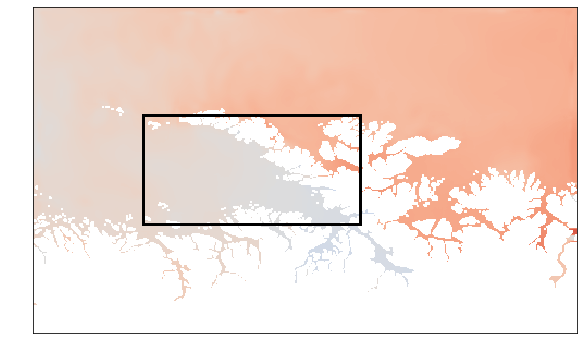

In [39]:
eta, hu, hv = sim.download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

import matplotlib.patches as patches
area = patches.Rectangle((loc[0][0], loc[0][1]), loc[1][1]-loc[0][1], loc[1][0]-loc[0][0], edgecolor='black', facecolor='none', lw=3)
ax.add_patch(area)

Extract local IC

In [40]:
sim.give_birth(gpu_ctx_refined, loc, 1.2)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


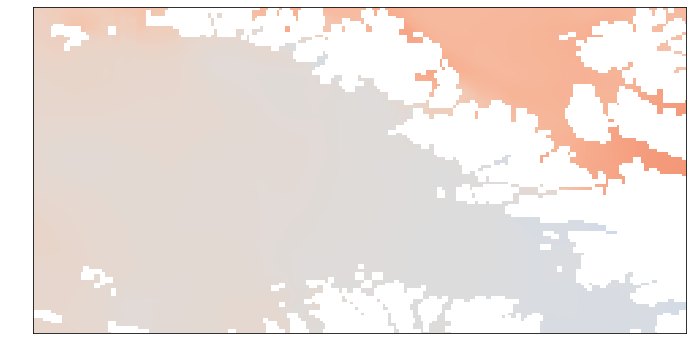

In [41]:
eta, hu, hv = sim.children[0].download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

### Time-Stepping

First model time step

In [42]:
sim.step(3600)

7200.0

In [43]:
eta, hu, hv = sim.download()
eta_refined, hu_refined, hv_refined = sim.children[0].download()

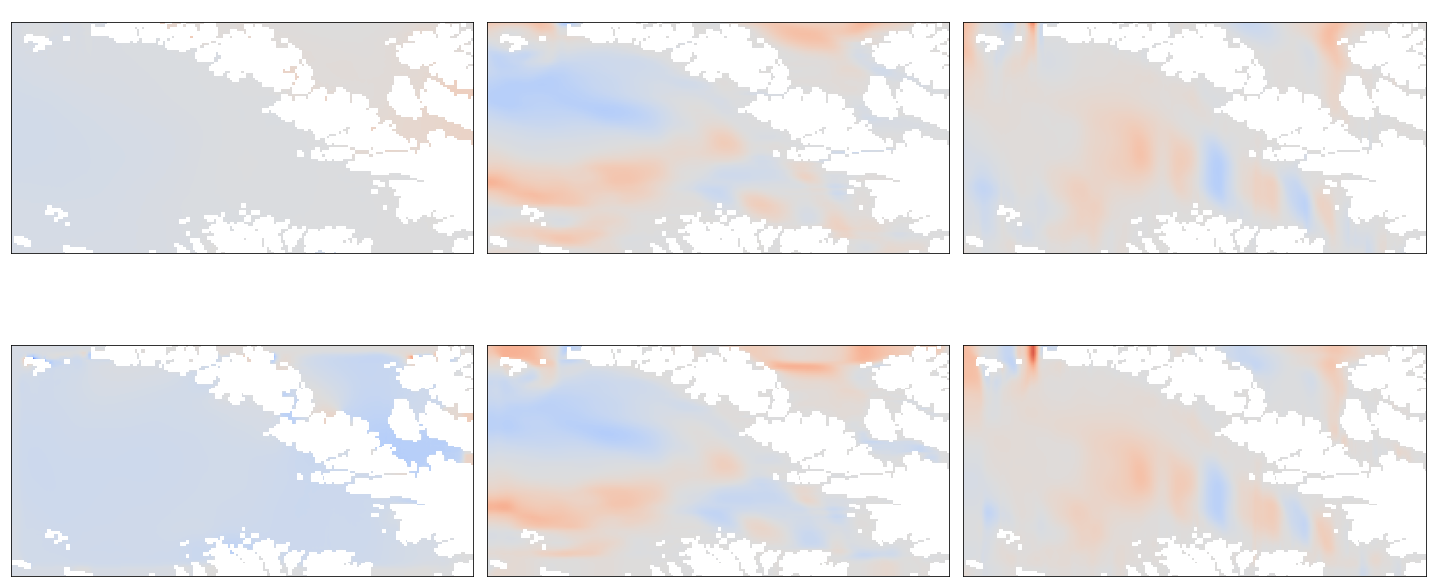

In [44]:
fig, axs = plt.subplots(2,3,figsize=(20,10))

axs[0,0].imshow(eta[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[0,0].set_title("eta (coarse)")
axs[0,1].imshow(hu[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,1].set_title("hu (coarse)")
axs[0,2].imshow(hv[loc[0][0]:loc[1][0],loc[0][1]:loc[1][1]], origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[0,2].set_title("hv (coarse)")

axs[1,0].imshow(eta_refined, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")
axs[1,0].set_title("eta (refined)")
axs[1,1].imshow(hu_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,1].set_title("hu (refined)")
axs[1,2].imshow(hv_refined, origin="lower", vmin=-100, vmax=100, cmap="coolwarm")
axs[1,2].set_title("hv (refined)")

for ax_s in axs:
    for ax in ax_s:
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])

plt.tight_layout()

### Sampling fine noise

In [45]:
fine_NX = np.ceil((sim.nx+4) * 1.2).astype(np.int32)
fine_NY = np.ceil((sim.ny+4) * 1.2).astype(np.int32)

fine_dx = sim.children[-1].dx
fine_dy = sim.children[-1].dy

In [46]:
import pycuda.driver as cuda
stream = cuda.Stream()

from gpuocean.SWEsimulators import OceanStateNoise
from importlib import reload
reload(OceanStateNoise)
small_scale_model_error = OceanStateNoise.OceanStateNoise(gpu_ctx, stream, fine_NX, fine_NY, fine_dx, fine_dy, sim.boundary_conditions, staggered=False, interpolation_factor=21, angle= NetCDFInitialization.get_texture(sim, "angle_tex"), coriolis_f=NetCDFInitialization.get_texture(sim, "coriolis_f_tex"))

from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
hu_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))
hv_pert = Common.CUDAArray2D(stream, fine_NX, fine_NY, 0,0, np.zeros((fine_NY, fine_NX)))


In [47]:
from gpuocean.utils import Common
fine_bathymetry = Common.Bathymetry(gpu_ctx, sim.gpu_stream, fine_NX, fine_NY, 0, 0, np.ones((fine_NY+1, fine_NX+1)))

small_scale_model_error.perturbOceanState(eta_pert, hu_pert, hv_pert, fine_bathymetry.Bi, 0.0, ghost_cells_x=0, ghost_cells_y=0)


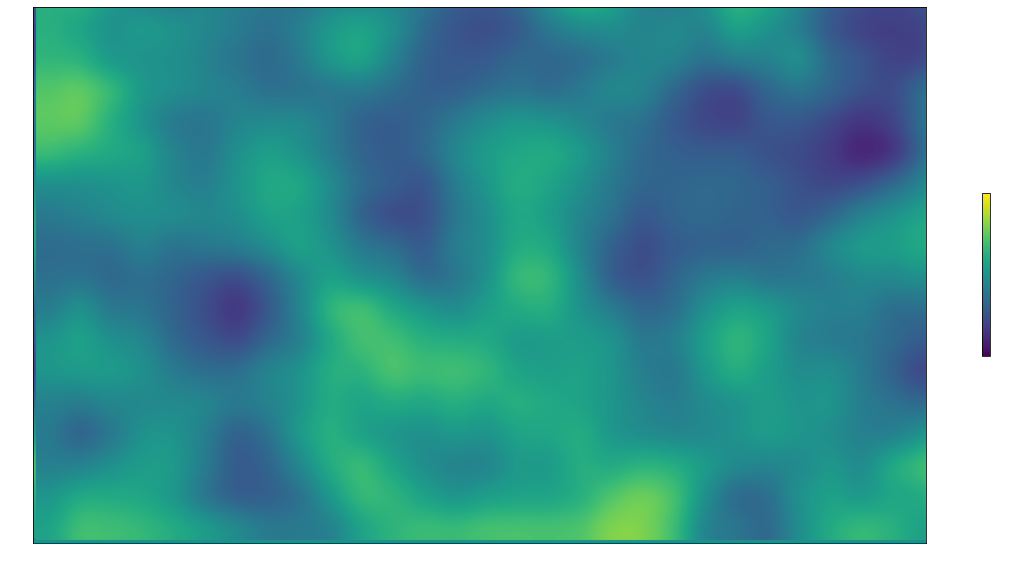

In [48]:
fig, axs = plt.subplots(1,1, figsize=(20,10))
im = axs.imshow(eta_pert.data.get(), vmin=-0.05, vmax=0.05, origin="lower")
# im = axs.imshow(np.roll(eta_pert.data.get(), -2, axis=1))
plt.colorbar(im, ax=axs, shrink=0.3)


In [49]:
fine_loc = np.round(np.array(loc)*sim.dx/fine_dx, 3)
fine_y0 = fine_loc[0][0]
fine_x0 = fine_loc[0][1]
fine_eta_pert = (1 - fine_x0%1 - fine_y0%1 + fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0):int(fine_y0+sim.children[0].ny+4),int(fine_x0):int(fine_x0+sim.children[0].nx+4)] \
                +  (fine_x0%1 - fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0):int(fine_y0+sim.children[0].ny+4),int(fine_x0+1):int(fine_x0+sim.children[0].nx+5)] \
                +  (fine_y0%1 - fine_x0%1*fine_y0%1) * eta_pert.data.get()[int(fine_y0+1):int(fine_y0+sim.children[0].ny+5),int(fine_x0):int(fine_x0+sim.children[0].nx+4)] \
                +  fine_x0%1*fine_y0%1 * eta_pert.data.get()[int(fine_y0+1):int(fine_y0+sim.children[0].ny+5),int(fine_x0+1):int(fine_x0+sim.children[0].nx+5)]

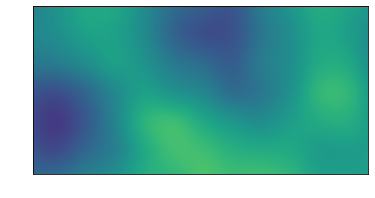

In [50]:
plt.imshow(fine_eta_pert, vmin=-0.05, vmax=0.05, origin="lower")

In [51]:
from gpuocean.utils import OceanographicUtilities
fine_bathymetry = Common.Bathymetry(gpu_ctx, sim.gpu_stream, fine_NX, fine_NY, 0, 0, OceanographicUtilities.rescaleIntersections(sim.bathymetry.Bi.data.get(), fine_NX+1, fine_NY+1)[2])



In [52]:
small_scale_model_error.geostrophicBalanceKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, stream,
                                                              small_scale_model_error.nx, small_scale_model_error.ny,
                                                              small_scale_model_error.dx, small_scale_model_error.dy,
                                                              np.int32(0), np.int32(0),

                                                              np.float32(sim.g), np.float32(0.0),
                                                              np.float32(0.0), np.float32(0.0),

                                                              eta_pert.data.gpudata, eta_pert.pitch,
                                                              eta_pert.data.gpudata, eta_pert.pitch,
                                                              hu_pert.data.gpudata, hu_pert.pitch,
                                                              hv_pert.data.gpudata, hv_pert.pitch,
                                                              fine_bathymetry.Bi.data.gpudata, fine_bathymetry.Bi.pitch,
                                                              sim.bathymetry.mask_value)

In [53]:
small_scale_model_error.nx

600

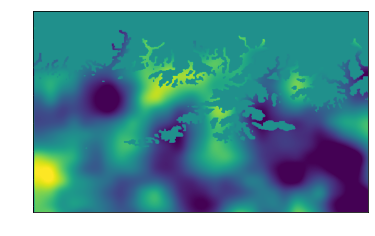

In [54]:
plt.imshow(eta_pert.data.get(),vmax=0.05, vmin=-0.05)

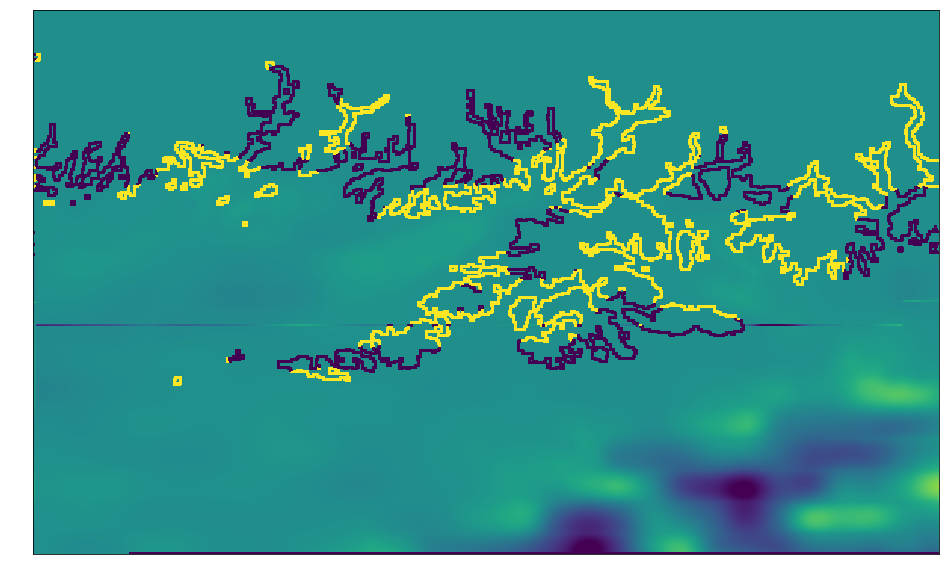

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(hu_pert.data.get(),vmax=250, vmin=-250)

In [58]:
eta_before = sim.download()[0]

In [59]:
sim.perturbState()

In [61]:
eta_after = sim.download()[0]

In [62]:
eta_after - eta_before

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)